In [1]:
import menzalib as mz
import numpy as np
import pylab as pl
from numpy import floor,log10,absolute,round,vectorize,transpose,sqrt
from scipy.optimize import curve_fit
from numpy.random import normal as nm

In [2]:
def ordina_2_vett(v1,v2):
	if len(v1)!=len(v2): return 0
	s1=np.sort(v1)
	s2=np.zeros(len(s1))
	for i in range(0,len(v1)):
		for j in range(0,len (v1)):
			if(s1[i]==v1[j]):
				s2[i]=v2[j]
				break
	return s1,s2

def errore_prodotto(x, dx, y, dy):
	return np.sqrt((y*dx)**2 + (x*dy)**2)

def errore_produttoria(x,dx):
	if len(x)!=len(dx): return 0
	temp=x[0]
	dtemp=dx[0]
	for i in range(1,len(x)):	
		dtemp=errore_prodotto(temp,dtemp,x[i],dx[i])
		temp=temp*x[i]
	return temp,dtemp

def lin(x,a,b):
	return a*x+b

In [3]:
Vt,dVt=[0.260,mz.dVosc(0.260)]#voltaggio in ingresso


f,df,deltaf,ddeltaf,V=np.genfromtxt('dati/1.txt',unpack='True')#aggiusta l'errore sullo sfasamento
ddeltaf=np.sqrt((0.02*deltaf)**2+ddeltaf**2)
#calcolo la fase
fase=360*f/deltaf
dfase=360*mz.drapp(f,df,deltaf,ddeltaf)

#metto i dati alla frequenza di taglio
f=np.append(f,1598.34)#frequenza di tagli
df=np.append(df,0.01)
V=np.append(V,182)#ampiezza di taglio
fase=np.append(fase,0)
dfase=np.append(dfase,0.08)#aggiusta l'errore sullo sfasamento

#ordino in i dati
f_temp=f
f,fase=ordina_2_vett(f,fase)
f,df=ordina_2_vett(f_temp,df)
f,V=ordina_2_vett(f_temp,V)
f,dfase=ordina_2_vett(f_temp,dfase)


fase[-2:]=-fase[-2:]#inverto la fase degli ultimi due dati
V=V/1000#passo in milivolt
dV=mz.dVosc(V)#calcolo l'errore del voltaggio
A=V/Vt#calcolo l'attenuazione
dA=mz.drapp(V,dV,Vt,dVt)#errore attenuazione

In [4]:
#tampa tabella misurazioni
#footnote='\\footnote{Ho misurato l\'errore sulla frequenza di trigger vedendo qual\'è l\'ultima cifra che balla}'
M=[mz.ne_tex(f/1000,df/1000),mz.ne_tex(V*1000,dV*1000),mz.ne_tex(20*np.log10(A),20* mz.dlog10(A,dA)),mz.ne_tex(fase,dfase)]
mz.mat_tex(M,'$f$[kHz] & $V_A$[mV] & $V_A/V_{in}[dB]$ & fase [gradi]','relazione/tabella.tex')

In [5]:
R=[9990,9910,9930,9880,9970]
dR=mz.dRdig(R)
C=[11.09e-9,9.76e-9]
dC=mz.dCdig(C,unit='1')

X=[R[0],R[1],C[0],C[1]]
dX=[dR[0],dR[1],dC[0],dC[1]]
X,dX=errore_produttoria(X,dX)
#print(X,dX)
# print(1/(2*np.pi*sqrt(X)),(1/2*np.pi)*mz.dpoli(X,dX,-1/2))

popt,pcov=curve_fit(lin,np.log10(f),fase,sigma=dfase)

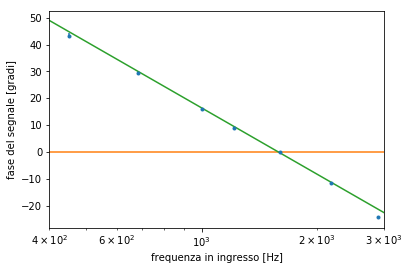

In [6]:
pl.errorbar(f,fase,yerr=dfase,fmt='.')
x=np.logspace(log10(400),log10(3000),30)
pl.plot(x,np.zeros(len(x)))#linea x=0
pl.plot(x,lin(np.log10(x),*popt))
pl.xlim(400,3000)
pl.xscale('log')
pl.ylabel('fase del segnale [gradi]')
pl.xlabel('frequenza in ingresso [Hz]')
pl.savefig('relazione/figure/1.png')
pl.show()
pl.close()

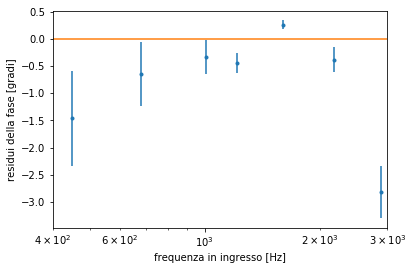

In [7]:
pl.errorbar(f,fase-lin(np.log10(f),*popt),yerr=dfase,fmt='.')
pl.plot([400,3000],[0,0])
pl.xlim(400,3000)
pl.xscale('log')
pl.ylabel('residui della fase [gradi]')
pl.xlabel('frequenza in ingresso [Hz]')
pl.savefig('relazione/figure/1res.png')
pl.show()
pl.close()

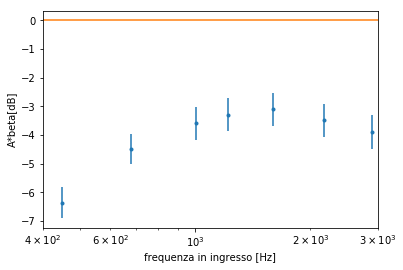

In [8]:
pl.errorbar(f,20*np.log10(A),yerr=20* mz.dlog10(A,dA),fmt='.')
pl.plot([400,3000],[0,0])#linea x=0
pl.xlim(400,3000)
pl.ylabel('A*beta[dB]')
pl.xlabel('frequenza in ingresso [Hz]')
pl.xscale('log')
pl.savefig('relazione/figure/2.png')
pl.show()
pl.close()

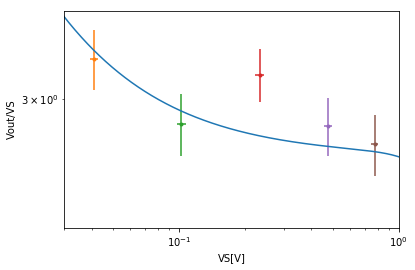

In [9]:
#trucco i dati per l'ultima parte del primo punto
Vs,Vout=np.genfromtxt('dati/dati_truccati_di_tiziano.txt',unpack=True)*2
dVs=mz.dVosc(Vs)
dVout=mz.dVosc(Vout)

A=Vout/Vs
dA=mz.drapp(Vout,dVout,Vs,dVs)

#plotto dati simulati
pl.plot(Vs,A)
pl.xscale('log')
pl.yscale('log')
pl.xlim(0.03,1)
pl.ylim(2.3,3.6)
#fine plottaggio dati simulati

pl.ylabel('Vout/VS')
pl.xlabel('VS[V]')
punti=[96,259,601,1159,1781]
vs=[]
vo=[]
a=[]
da=[]
for i in range(len(punti)):
	vs.append(nm(Vs[punti[i]],dVs[punti[i]]))
	a.append(nm(A[punti[i]],dA[punti[i]]))
	da.append(dA[punti[i]])
	vo.append(nm(Vout[punti[i]],dVout[punti[i]]))
	pl.errorbar(vs[i],a[i],yerr=dA[punti[i]],xerr=dVs[punti[i]],fmt='.')

pl.savefig('relazione/figure/1b.png')
pl.show()
M=[mz.ne_tex(vs,mz.dVosc(vs)),mz.ne_tex(vo,mz.dVosc(vo)),mz.ne_tex(a,da)]
mz.mat_tex(M,'$V_S[V]$ & $V_{out}[V]$ & $V_{out}/V_S$','relazione/tab2.tex')

In [16]:
ls

Codice.ipynb                      relazione/
Es07.Opamp OscWien.pdf            relazione.aux
Oscillatore sinusoidale Wien.pdf  relazione.log
analisi.py                        relazione.out
dati/                             relazione.pdf
